# Hourly Bike Rental Prediction

##### Quick Links: [Exploratory Data Visualization](#Exploratory-Data-Visualization) | [Feature Engineering](#Feature-Engineering) | [Model Fitting](#Model-Fitting) | [Conclusions](#Conclusions)

---

<p style='text-align: justify;'>
American cities that have communal bike sharing stations that allows renting of bicycles, such as Washington, D.C., collects data on the number of bicycles rented by the hour or day.

For this project, we will be focusing on trying to predict bike rental in a given hour using the <a href='http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset'>Bike Sharing Dataset</a>, a .CSV file that contains <code>17380</code> rows, with each row representing the number of bike rentals for a single hour of a single day.
</p>

Here are the descriptions of the relevant columns:
- <code>instant</code> - A unique sequential ID number for each row
- <code>dteday</code> - The date of the rentals
- <code>season</code> - The season in which the rentals occurred
- <code>yr</code> - The year the rentals occurred
- <code>mnth</code> - The month the rentals occurred
- <code>hr</code> - The hour the rentals occurred
- <code>holiday</code> - Whether or not the day was a holiday
- <code>weekday</code> - The day of the week (as a number, 0 to 7)
- <code>workingday</code> - Whether or not the day was a working day
- <code>weathersit</code> - The weather (as a categorical variable)
- <code>temp</code> - The temperature, on a 0-1 scale
- <code>atemp</code> - The adjusted temperature
- <code>hum</code> - The humidity, on a 0-1 scale
- <code>windspeed</code> - The wind speed, on a 0-1 scale
- <code>casual</code> - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- <code>registered</code> - The number of registered riders (people who had already signed up)
- <code>cnt</code> - The total number of bike rentals (casual + registered)

### Goals
<p style='text-align: justify;'>
We will be using <code>cnt</code> as the dependent variable while all the other columns except for <code>casual</code> and <code>registered</code> will be used as features. We will be simultaneously making a few different models and evaluating their performances.
</p>

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

sns.set_style("white")
%matplotlib inline

# read-in the data
bike_rentals = pd.read_csv('bike_rental_hour.csv')

bike_rentals.head() # first few rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Exploratory Data Visualization

<p style='text-align: justify;'>
Let's plot out the distribution of the number of bike rentals using a histrogram and a boxplot, and create a correlation matrix plot between the features and our response.
</p>

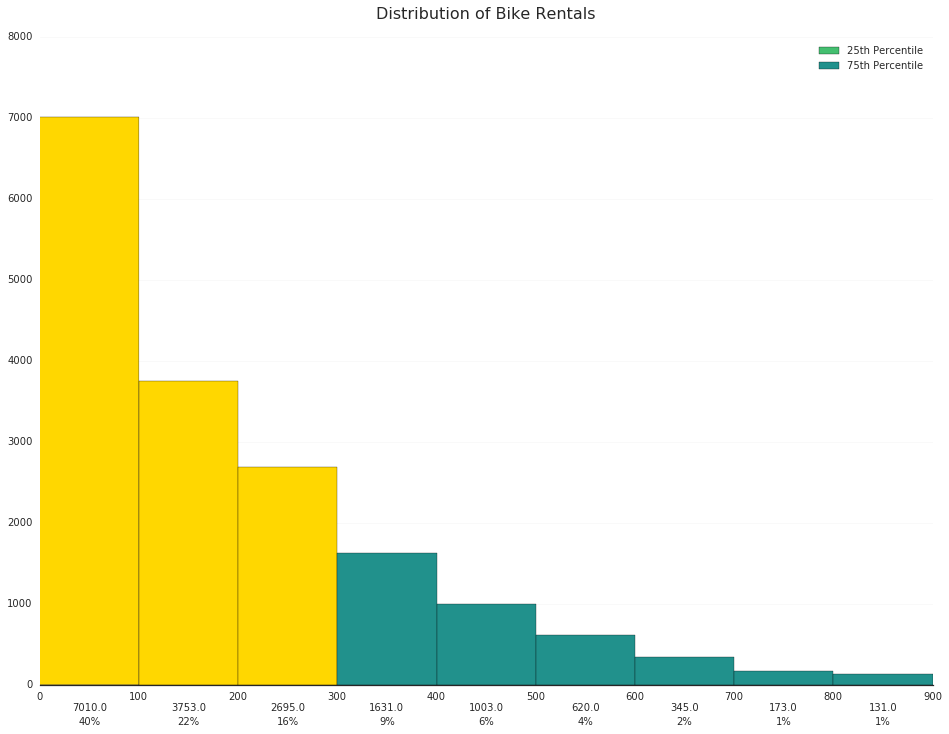

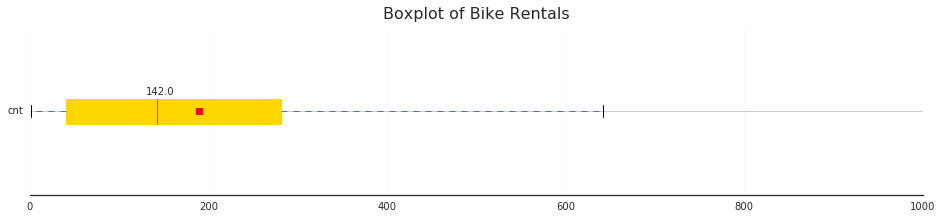

In [2]:
# define histogram function
def histog(data, figsize = (4, 3), title = "My Histogram",
           bins = 10, setticks = False,
           getQuartiles = False,
           getPercentages = False,
           withDecimal = False,
           xlabel = "", ylabel = "",
           xlim = 0, ylim = 0, grid = False,
           color = "gold", edgecolor = "black", 
           color25 = "green", color75 = "red",
           alpha = 1, rotation = 0):
    
    fig, ax = plt.subplots(figsize = figsize)

    counts, bins, patches = ax.hist(data, facecolor = color, 
                                    edgecolor = edgecolor, 
                                    bins = bins, alpha = alpha)

    # Set the ticks to be at the edges of the bins
    if setticks == True:
        ax.set_xticks(bins)
        ax.set_xticklabels(bins, rotation = rotation)
        if getQuartiles == True or getPercentages == True:
            plt.subplots_adjust(bottom = 0.5)
        

    # Set the xaxis's tick labels to be formatted with 1 decimal place
    if withDecimal == True:
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

    # Change the colors of bars at the edges...
    if getQuartiles == True:
        twentyfifth, seventyfifth = np.percentile(data, [25, 75])
        for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
            if rightside < twentyfifth:
                patch.set_facecolor(color25)
            elif leftside > seventyfifth:
                patch.set_facecolor(color75)
        handles = [Rectangle((0, 0), 1, 1, color = c, ec = "k") for c in [color25, color75]]
        labels  = ["25th Percentile", "75th Percentile"]
        plt.legend(handles, labels)

    # Label the raw counts and the percentages below the x-axis
    if getPercentages == True:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):

            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                        xytext=(0, -32), textcoords='offset points', va='top', ha='center')

        # Give ourselves some more room at the bottom of the plot
        plt.subplots_adjust(bottom=.15)

    ax.set_title(title, y = 1.02, size = 16)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(grid, alpha = 0.1, axis = "y")
    ax.tick_params(left = "off", top = "off", right = "off")
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    plt.show()
    
# plotting histogram
cmap = plt.get_cmap('viridis')
cmap25 = cmap(0.7)
cmap75 = cmap(0.5)

histog(bike_rentals["cnt"], figsize = (16, 12), 
       bins = np.arange(0, bike_rentals["cnt"].max(), 100),  
       color25 = cmap25, color75 = cmap75,
       getQuartiles = True, getPercentages = True, 
       color = "gold",
       title = "Distribution of Bike Rentals")

# plotting boxplot
bike_rental_median = bike_rentals["cnt"].median()

fig = plt.figure(figsize = (16, 3))
ax1 = plt.subplot(1, 1, 1)
ax1.set_title("Boxplot of Bike Rentals", y = 1.02, size = 16)
ax1.text(bike_rental_median-12, 1.1, bike_rental_median) # label the median
ax1.tick_params(left = "off", top = "off", right = "off")
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)
ax1.spines["top"].set_visible(False)  
ax1.grid(alpha = 0.1, axis = "x")

boxprops = dict(boxes = "gold")
bike_rentals["cnt"].plot.box(vert = False, showmeans = True,
                             grid = True, color = boxprops,
                             patch_artist = True, ax = ax1)

<p style='text-align: justify;'>
Looking at the above exploratory plots, the distribution is skewed to the right in that most of the time, the number of bikes rented by the hour are largely from <code>0</code> to <code>300</code> with the median being <code>142</code> bikes rented. The most number of bikes rented ever seems to be almost <code>900</code>. The boxplot also shows that the variation in the number of bicycles rented is large with many outlying values.
</p>

<p style='text-align: justify;'>
Now let's look at the correlations! In our plot, we'll mask absolute values under <code>0.3</code> to see which correlations are sufficiently large.
</p>

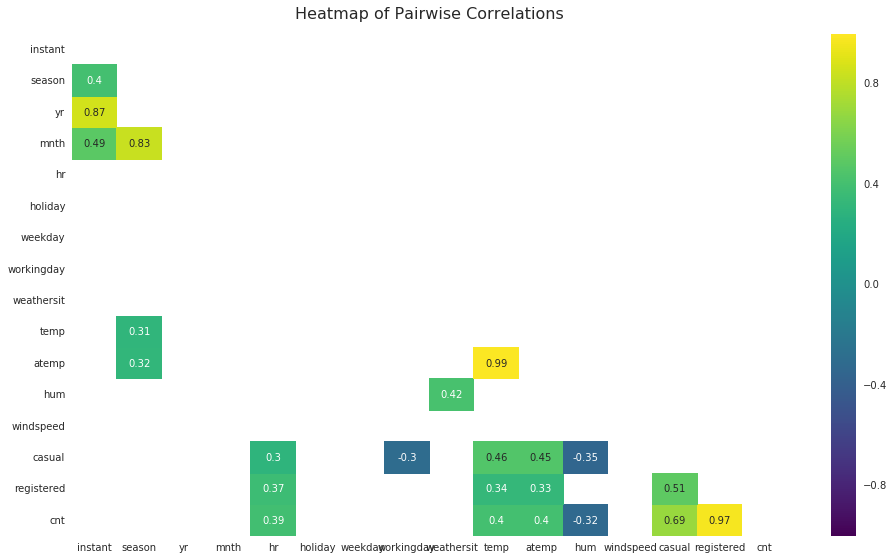

In [3]:
corrmat = bike_rentals.corr()

# setup up axes
fig, ax3 = plt.subplots(figsize = (16, 9))
ax3.set_title("Heatmap of Pairwise Correlations", size = 16, y = 1.02)

# Mask upper triangle of off-diagonals
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(corrmat)] = True
mask[np.abs(corrmat) <= 0.3] = True

# generate heatmap
sns.heatmap(corrmat, annot = True, ax = ax3,
            cmap = "viridis", mask = mask)

Ignoring both <code>casual</code> and <code>registered</code>, the features that correlate strongly with <code>cnt</code> are:
- Positive Corr.: <code>hr</code>, <code>temp</code>, and <code>atemp</code>
- Negative Corr.: <code>hum</code>

<p style='text-align: justify;'>
Most of the other features don't seem to correlate well with each other, but this may also have to with them being categorical and/or time-series in nature. From the above plot, as the temperature goes up, so does the number of bikes rented, while the opposite is true when the humidity is high.
</p>

### Feature Engineering
<p style='text-align: justify;'>
While the the values under <code>hr</code> are numerical, it may be better to introduce some order in that column by creating another column with labels for <code>morning</code>, <code>afternoon</code>, <code>evening</code>, and <code>night</code>.
</p>

In [4]:
# define label assignment by hour function
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4 # Morning
    elif hour >= 6 and hour < 12:
        return 1 # Afternoon
    elif hour >= 12 and hour < 18:
        return 2 # Evening
    elif hour >= 18 and hour <= 24:
        return 3 # Night
    
# make new column
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

print("[NEW TIMES]")
for code, name in zip([4, 1, 2, 3], ["Morning", "Afternoon", "Evening", "Night"]):
    print("{}: {}".format(code, name))
          
bike_rentals["time_label"].value_counts().reindex([4, 1, 2, 3]).rename(index = dict(zip([4, 1, 2, 3], ["Morning", "Afternoon", "Evening", "Night"])))

[NEW TIMES]
4: Morning
1: Afternoon
2: Evening
3: Night


Morning      4276
Afternoon    4360
Evening      4375
Night        4368
Name: time_label, dtype: int64

### Model Fitting

<p style='text-align: center;'><b><i>Let's build some models!</i></b></p>

##### Choosing an Error Metric
<p style='text-align: justify;'>
Before we train our models, let's choose the appropriate error metric to evaluate them. Since our response variable is continuous data, let's make use of the Root Mean Squared Error or RMSE to see how close our predictions are to the actual data.
</p>

##### Splitting the Data
<p style='text-align: justify;'>
For splitting the dataset, we'll select <code>80%</code> of the rows to be in our <code>train</code> set, and the remaining rows to be in the <code>test</code> set.
</p>

##### Algorithms and Models to Use
<p style='text-align: justify;'>
Since our goal is to predict bike rentals wherein we won't be doing classification, let's make use of Linear Regression, the Decision Tree Algorithm, and the Random Forest Algorithm.
</p>

<p style='text-align: justify;'>
Our list of features should exclude <code>cnt</code>, <code>casual</code>, <code>dteday</code> (the date of the rental instance), <code>registered</code>, <code>temp</code> (in favor of <code>atemp</code>), <code>hr</code>, <code>yr</code> (in favor of <code>mnth</code> and <code>hr</code>), and <code>instant</code> (a unique ID for each row). Furthermore, we would need to convert some variables as categorical (some as ordinal like in <code>time_label</code>).
</p>

In [5]:
# let's make a copy of bike_rentals
df = bike_rentals.copy()

# get final list of features
features = df.columns.drop(["cnt", "casual", "dteday", "registered", "instant", "temp","hr", "yr"])

print("[Final Features]")
print("\n".join(features))

# recoding as categorical
categoricals = ["season", "mnth", "holiday", "weekday", "workingday", "weathersit", "time_label"]

for col in categoricals:
    colnew = pd.Categorical(df[col])
    df[col] = colnew
    
    if col == "time_label":
        df[col] = df[col].cat.reorder_categories([4, 1, 2, 3], ordered = True)
    
df[categoricals].head(20)
df[categoricals].describe()

[Final Features]
season
mnth
holiday
weekday
workingday
weathersit
atemp
hum
windspeed
time_label


,season,mnth,holiday,weekday,workingday,weathersit,time_label
count,17379,17379,17379,17379,17379,17379,17379
unique,4,12,2,7,2,4,4
top,3,7,0,6,1,1,2
freq,4496,1488,16879,2512,11865,11413,4375


### Linear Regression
---

In [6]:
# get training and test sets
train = df.sample(frac = 0.8)
test  = df.drop(train.index)

# instantiate LR class
lm = LinearRegression()

# fit using train
lm = lm.fit(train[features], train["cnt"])

# predict using test 
pred_lm = lm.predict(test[features])

# get MSE
rmse_lm = np.sqrt(mean_squared_error(test["cnt"], pred_lm))

pred_lm_train = lm.predict(train[features])
rmse_lm_train = np.sqrt(mean_squared_error(train["cnt"], pred_lm_train))

print(">>> Linear Regression RMSE:", rmse_lm)
print("    Train RMSE for Checking:", rmse_lm_train)

>>> Linear Regression RMSE: 141.09349682710376
    Train RMSE for Checking: 145.3718185157331


<p style='text-align: justify;'>
An RMSE of <code>144.48</code> means that on the average, the predictions are off by that amount. Predicting on the training set returns similar performance which tells us that the model is at the very least not overfitting.
</p>

<p style='text-align: justify;'>
Knowing the range of the values of the response variables, the error seems to be very high. This high bias may be due to outliers in the data, or there may be unmeasured features that we fail to include in our model, or underfitting which is common for simple Linear Regression models. For now, let's see how the other algorithms will perform.
</p>

### Decision Trees
---
For decision trees, we'll also try to experiment with different parameter settings.

In [7]:
# instantiate DT class
# keep default parameters for now
dt = DecisionTreeRegressor()

# fit using train
dt = dt.fit(train[features], train["cnt"])

# predict using test
pred_dt = dt.predict(test[features])

# get MSE
rmse_dt = np.sqrt(mean_squared_error(test["cnt"], pred_dt))

pred_dt_train = dt.predict(train[features])
rmse_dt_train = np.sqrt(mean_squared_error(train["cnt"], pred_dt_train))

print(">>> Decision Tree RMSE:", rmse_dt)
print("    Train RMSE for Checking:", rmse_dt_train)

>>> Decision Tree RMSE: 157.81940544928824
    Train RMSE for Checking: 19.92604060400212


<p style='text-align: justify;'>
Initial results show that keeping the default parameters gives us poor predictions even when compared to those of the linear model fit. Furthermore, the very small RMSE on the training set predictions in contrast with the test set predictions tell us that the initial model extremely overfits. Thus, let's now try changing the parameters from their default settings. 
</p>

To recall, here are some of them:
- <code>max_depth</code>: Globally restricts how deep the tree can go.
- <code>min_samples_split</code>: The minimum number of rows a node should have before it can be split; if this is set to 2 then nodes with two rows won't be split and will become leaves instead.
- <code>min_samples_leaf</code>: The minimum number of rows a leaf must have.
- <code>min_weight_fraction_leaf</code>: The fraction of input rows a leaf must have.
- <code>max_leaf_nodes</code>: The maximum number of total leaves; this will limit the number of leaf nodes as the tree is being built.

In [8]:
dt2 = DecisionTreeRegressor(min_samples_split = 20,
                            min_samples_leaf = 25)
dt2 = dt2.fit(train[features], train["cnt"])

pred_dt2 = dt2.predict(test[features])
rmse_dt2 = np.sqrt(mean_squared_error(test["cnt"], pred_dt2))

pred_dt2_train = dt2.predict(train[features])
rmse_dt2_train = np.sqrt(mean_squared_error(train["cnt"], pred_dt2_train))

print(">>> Tuned Decision Tree RMSE:", rmse_dt2)
print("    Train RMSE for Checking:", rmse_dt2_train)

>>> Tuned Decision Tree RMSE: 125.10143752748563
    Train RMSE for Checking: 115.65335817215274


<p style='text-align: justify;'>
Experimenting with different values for <code>min_samples_split</code> and <code>min_samples_leaf</code> which both control for overfitting by allowing us to "simplify" the trees significantly improved our model's performance! The RMSE between train and test set predictions are now also comparable, showing that the problem of overfitting is resolved.
</p>

<p style='text-align: justify;'>
A reasonable follow-up question now would be: which between the two parameters should we prioritize with finding the best setting in terms of improving the prediction performance? For now, we can try to plot the RMSE values over a set of increasing <code>min_samples_split</code> and <code>min_samples_leaf</code> values, while fixing the other, to see how it affects them.
</p>

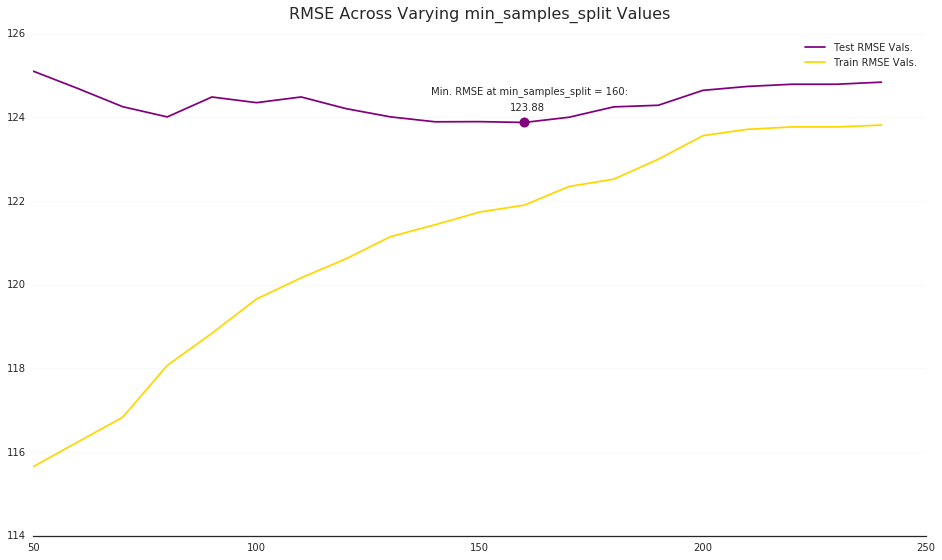

In [9]:
# for a range of min_samples_split
mss_range = np.arange(50, 250, 10)

mss_range_rmse = []
mss_range_rmse_train = []

for mss in mss_range:
    dt3 = DecisionTreeRegressor(min_samples_split = mss,
                                min_samples_leaf = 25)
    dt3 = dt3.fit(train[features], train["cnt"])

    pred_dt3 = dt3.predict(test[features])
    rmse_dt3 = np.sqrt(mean_squared_error(test["cnt"], pred_dt3))

    pred_dt3_train = dt3.predict(train[features])
    rmse_dt3_train = np.sqrt(mean_squared_error(train["cnt"], pred_dt3_train))
    mss_range_rmse.append(rmse_dt3)
    mss_range_rmse_train.append(rmse_dt3_train)

# get min RMSEs
mss_mse_min = min(mss_range_rmse)
mss_mse_min_index = mss_range[mss_range_rmse.index(min(mss_range_rmse))]
mss_mse_train_min = min(mss_range_rmse_train)
    
fig = plt.figure(figsize = (16, 9))
ax4 = plt.subplot(1, 1, 1)
ax4.grid(alpha = 0.1, axis = "y")
ax4.tick_params(left = "off", top = "off", right = "off")
ax4.spines["right"].set_visible(False)    
ax4.spines["left"].set_visible(False)
ax4.spines["top"].set_visible(False)  
ax4.grid(alpha = 0.1, axis = "y")
ax4.set_title("RMSE Across Varying min_samples_split Values", y = 1.02, size = 16)
ax4.text(mss_mse_min_index - 3.2, mss_mse_min + 0.3, round(mss_mse_min, 2))
ax4.text(mss_mse_min_index - 21, mss_mse_min + 0.7, "Min. RMSE at min_samples_split = {}:".format(mss_mse_min_index))

# ax4.axhline(mss_mse_min, c = "purple", alpha = 0.2)
# ax4.axhline(mss_mse_train_min, c = "gold", alpha = 0.2)

plt.plot(mss_range, mss_range_rmse, color = "purple", label = "Test RMSE Vals.")
plt.plot(mss_range, mss_range_rmse_train, color = "gold", label = "Train RMSE Vals.")
plt.plot(mss_mse_min_index, mss_mse_min, marker = 'o', markersize = 10, color = "purple")
plt.legend()

<p style='text-align: justify;'>
The best RMSE was achieved at a <code>min_samples_split</code> value of <code>123.88</code>. It seems that, for a fixed value of minimum number or rows a leaf must have, varying <code>min_samples_split</code> does not seem to have a very big effect on the prediction accuracy of the model. We can see how larger values introduced more complexity in the model, causing the train RMSE to rise monotonically.
</p>

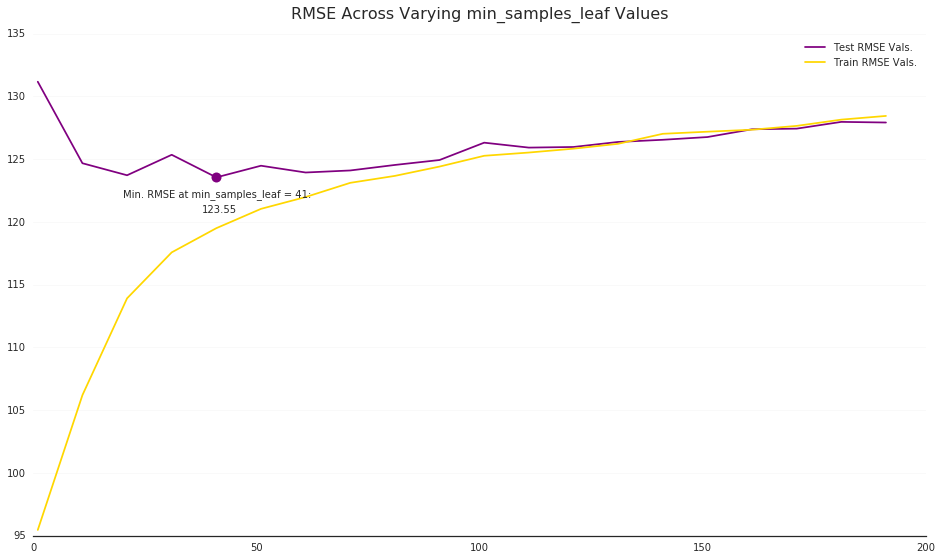

In [10]:
# for a range of min_samples_leaf
msl_range = np.arange(1, 200, 10)

msl_range_rmse = []
msl_range_rmse_train = []

for msl in msl_range:
    dt4 = DecisionTreeRegressor(min_samples_split = 20,
                                min_samples_leaf = msl)
    dt4 = dt4.fit(train[features], train["cnt"])

    pred_dt4 = dt4.predict(test[features])
    rmse_dt4 = np.sqrt(mean_squared_error(test["cnt"], pred_dt4))

    pred_dt4_train = dt4.predict(train[features])
    rmse_dt4_train = np.sqrt(mean_squared_error(train["cnt"], pred_dt4_train))
    msl_range_rmse.append(rmse_dt4)
    msl_range_rmse_train.append(rmse_dt4_train)

# get min RMSEs
msl_mse_min = min(msl_range_rmse)
msl_mse_min_index = msl_range[msl_range_rmse.index(min(msl_range_rmse))]
msl_mse_train_min = min(msl_range_rmse_train)
    
fig = plt.figure(figsize = (16, 9))
ax5 = plt.subplot(1, 1, 1)
ax5.grid(alpha = 0.1, axis = "y")
ax5.tick_params(left = "off", top = "off", right = "off")
ax5.spines["right"].set_visible(False)    
ax5.spines["left"].set_visible(False)
ax5.spines["top"].set_visible(False)  
ax5.grid(alpha = 0.1, axis = "y")
ax5.set_title("RMSE Across Varying min_samples_leaf Values", y = 1.02, size = 16)
ax5.text(msl_mse_min_index - 3.3, msl_mse_min - 2.8, round(msl_mse_min, 2))
ax5.text(msl_mse_min_index - 21, msl_mse_min - 1.5, "Min. RMSE at min_samples_leaf = {}:".format(msl_mse_min_index))

plt.plot(msl_range, msl_range_rmse, color = "purple", label = "Test RMSE Vals.")
plt.plot(msl_range, msl_range_rmse_train, color = "gold", label = "Train RMSE Vals.")
plt.plot(msl_mse_min_index, msl_mse_min, marker = 'o', markersize = 10, color = "purple")
plt.legend()

<p style='text-align: justify;'>
Comparatively,  <code>min_samples_leaf</code> readily resolves overfitting even at low values.
</p>

### Random Forest Algorithm
---
<p style='text-align: justify;'>
We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.
</p>

In [11]:
# instantiate RF class
# keep default parameters for now
rf = RandomForestRegressor()
rf = rf.fit(train[features], train["cnt"])

pred_rf = rf.predict(test[features])
rmse_rf = np.sqrt(mean_squared_error(test["cnt"], pred_rf))

pred_rf_train = rf.predict(train[features])
rmse_rf_train = np.sqrt(mean_squared_error(train["cnt"], pred_rf_train))

print(">>> Random Forest RMSE:", rmse_rf)
print("    Train RMSE for Checking:", rmse_rf_train)

>>> Random Forest RMSE: 121.61159321360512
    Train RMSE for Checking: 54.20778996395929


<p style='text-align: justify;'>
The Random Forest model performed much better at default parameter settings compared to the Decision Tree regressor at both prediction and lessening overfitting, though it is still very much present for now. Let's try experimenting with different parameters!
</p>

<p style='text-align: justify;'>
To recall, the Random Forest algorithm is an example of an ensemble algorithm in that it combines multiple decision trees and averages the results over all of those in order to reduce variance. Specifically, we can make use of Bootstrap Aggregation, or Bagging (defaults to <code>True</code> in RandomForestRegressor), wherein we take bootstrap samples from the training set to train across repeated samples and average the predictions. Another important distinction between RF and DT is that when we build our decision trees, each time there is a split, a random selection of predictors is chosen to serve as candidates for the best-column-to-split-with. Typically, we randomly select $m\approx\sqrt{p}$ predictors where $p$ is the total number of features. This is yet another parameter that we can tune later on.
</p>

For the <code>sklearn</code> implementation, aside from earlier aforementioned parameters, we can also look at:
- <code>n_estimators</code>: The number of trees in the forest.
- <code>max_features</code>: The number of features to consider when looking for the best split.

In [12]:
# with feature subsetting
rf2 = RandomForestRegressor(n_estimators = 150,
                            max_features = "sqrt",
                            max_depth = 12,
                            min_samples_split = 5)
rf2 = rf2.fit(train[features], train["cnt"])

pred_rf2 = rf2.predict(test[features])
rmse_rf2 = np.sqrt(mean_squared_error(test["cnt"], pred_rf2))

pred_rf2_train = rf2.predict(train[features])
rmse_rf2_train = np.sqrt(mean_squared_error(train["cnt"], pred_rf2_train))

print(">>> Tuned Random Forest RMSE:", rmse_rf2)
print("    Train RMSE for Checking:", rmse_rf2_train)

>>> Tuned Random Forest RMSE: 114.37832708478962
    Train RMSE for Checking: 102.35110770080958


<p style='text-align: justify;'>
This is our best predicting model yet! We can see just how much we can experiment further and achieve better results given a dedicated grid search of optimal parameters.
</p>

### Conclusions
<p style='text-align: justify;'>
Temperature, humidiy, and wind speed are all reliable predictors of bike rentals, but there are many more factors to consider that we may not be capturing in our model, causing bias. For example, the geographic location of the rental service as well as the customers may also show a spatial effect on rentals. Time is also another factor to consider, though in our model the seasons, months, and hours were taken into account by introducing them as categorical variables.
</p>

Among the models we used, the Random Forest Algorithm proved to be the best in predictive accuracy while avoiding overfitting. We were also able to see that tuning the parameters for each of the algorithms offered different, but improved results, which allows us to pose questions on where to start with paramter tuning and in what direction we should take the model. It's important to note that an analytical solution isn't readily available for this aside from using performance metrics and casting a wide net over what subsets of values to consider. Increasing complexity should still be taken into account as the variance may rise unnoticed and cost plenty more computing time.

#### For Improvements
- We can do ensemble methods of modeling to see how the differences between the algorithms can help in improving overall predictive performance.
- We can visualize further different settings for the parameters over many more bags, feature subsets, and number of trees to help us choose.
- Do cross-validation in finding optimal paramters